In [1]:
import numpy as np
import pandas as pd
import re
import fasttext
import itertools
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import requests
import selenium
import time
import random
import glob

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
from collections import Counter
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from scipy import ndimage
from numpy import inf
from numpy.lib import stride_tricks
from sklearn.model_selection import train_test_split
from keras import backend as K, regularizers
from keras.models import Model, load_model, Sequential
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import LeakyReLU, PReLU, ELU, Input, GaussianDropout, Activation, GaussianNoise, Lambda, Bidirectional,concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM, GlobalMaxPooling1D, GlobalAveragePooling1D, CuDNNGRU, Embedding
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, Conv1D, Conv2D
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
with open('34_papers_abstract.txt', 'r', encoding='utf-8-sig') as f:
    total_raw = [x.strip() for x in f.readlines()]

In [4]:
len(total_raw)

34

In [5]:
total_raw[0]

'The global spread of SARS-CoV-2 requires an urgent need to find effective therapeutics for the treatment of COVID-19. We developed a data-driven drug repositioning framework, which applies both machine learning and statistical analysis approaches to systematically integrate and mine large-scale knowledge graph, literature and transcriptome data to discover the potential drug candidates against SARS-CoV-2. The retrospective study using the past SARS-CoV and MERS-CoV data demonstrated that our machine learning based method can successfully predict effective drug candidates against a specific coronavirus. Our in silico screening followed by wet-lab validation indicated that a poly-ADP-ribose polymerase 1 (PARP1) inhibitor, CVL218, currently in Phase I clinical trial, may be repurposed to treat COVID-19. Our in vitro assays revealed that CVL218 can exhibit effective inhibitory activity against SARS-CoV-2 replication without obvious cytopathic effect. In addition, we showed that CVL218 is 

In [6]:
model = fasttext.load_model('./litcovid/litcovid_fasttext_0623.bin')

In [7]:
model.get_words()

['covid-19',
 'sars-cov-2',
 'patients',
 'drug',
 'coronavirus',
 'drugs',
 'treatment',
 'disease',
 'clinical',
 'infection',
 'virus',
 'respiratory',
 'pandemic',
 'viral',
 'severe',
 'potential',
 'antiviral',
 'health',
 'study',
 'trials',
 'use',
 'novel',
 'used',
 'acute',
 'studies',
 'syndrome',
 'effective',
 'also',
 'hydroxychloroquine',
 'human',
 'new',
 'data',
 'therapeutic',
 'results',
 'available',
 'protein',
 'trial',
 'binding',
 'china',
 'current',
 'ace2',
 'effects',
 'caused',
 'including',
 'using',
 'care',
 'cases',
 'however',
 'two',
 'group',
 'high',
 'review',
 'world',
 'outbreak',
 'approved',
 'development',
 'global',
 'therapy',
 'currently',
 'efficacy',
 'hcq',
 'associated',
 'compounds',
 'control',
 'cells',
 'risk',
 'need',
 'reported',
 'based',
 'chloroquine',
 'evidence',
 'sars-cov',
 'several',
 'remdesivir',
 'inhibitors',
 'research',
 'diseases',
 'safety',
 'patient',
 'target',
 'protease',
 'specific',
 'spread',
 'first',


In [8]:
len(model.get_labels())

1447

In [9]:
def preprocess(txt):
    b = txt.replace('i.e.','')

    b = b.replace('-\n\n', '')
    b = b.replace('\n\n', ' ')
    b = b.replace('\n', ' ')
    
    b = b.replace('\n\n', ' ')
    b = b.replace('\n', ' ')
    b = b.replace('\n\n', ' ')
    b = b.replace('\n', ' ')
    
    b = b.replace('(', ' ')
    b = b.replace(')', ' ')
    b = b.replace(',', '')
    
    b = re.sub('[^\#0-9A-Za-z-]', ' ',b)
    b = re.sub(' +', ' ',b)
    b= b.strip()

    # print(b)
#     b = b.lower()
    if 'References' in b and len(b.split('References')[0])>15:
        b = b.split('References')[0]
    if 'Introduction' in b:
        b = b.split('Introduction')[1]
    if 'Abstract' in b:
        b = b.split('Abstract')[1]
    b = b.lower()    
    b = b.replace('et al.','')
    b = b.replace('table','')
    b = b.replace('figure','')

    return b

In [10]:
new_total_raw = [preprocess(x) for x in total_raw]

In [11]:
new_total_raw[0]

'the global spread of sars-cov-2 requires an urgent need to find effective therapeutics for the treatment of covid-19 we developed a data-driven drug repositioning framework which applies both machine learning and statistical analysis approaches to systematically integrate and mine large-scale knowledge graph literature and transcriptome data to discover the potential drug candidates against sars-cov-2 the retrospective study using the past sars-cov and mers-cov data demonstrated that our machine learning based method can successfully predict effective drug candidates against a specific coronavirus our in silico screening followed by wet-lab validation indicated that a poly-adp-ribose polymerase 1 parp1 inhibitor cvl218 currently in phase i clinical trial may be repurposed to treat covid-19 our in vitro assays revealed that cvl218 can exhibit effective inhibitory activity against sars-cov-2 replication without obvious cytopathic effect in addition we showed that cvl218 is able to suppr

###### Stopwords 처리

In [12]:
from nltk.corpus import stopwords

sw = stopwords.words("english")

sw.append(',')

sw.extend(['a', 'about', 'above', 'after', 'again', 'against',        'all', 'am', 'an', 'and', 'any', 'are',                   'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by',        'could',                            'did',                   'do', 'does',                     'doing',                 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had',                   'has',                   'have',                     'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is',                 'it', "it's", 'its', 'itself', "let's",                 'me',                       'more', 'most',                     'my', 'myself',                           'nor',                    'of',        'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own',            'same',                   'she', "she'd", "she'll", "she's", 'should',                                      'so', 'some', 'such',      'than', 'that',            "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up',       'very', 'was',                   'we', "we'd", "we'll", "we're", "we've", 'were',                     'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why',         "why's", 'with',                 'would',                            'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])

sw = list(set(sw))

sw.remove('his')

In [13]:
b = []
for x in new_total_raw:
    c = x.split()
    c = [y for y in c if y not in sw]
    c = [y for y in c if y not in ['sars-cov-2','covid-19', '2019-ncov', 'severe', 'acute', 'respiratory','syndrome','sars','coronavirus']]
    c = [y for y in c if 'corona' not in y]
    c = [y for y in c if y!='cov' and y!='covs']
    c = [y for y in c if y.isnumeric()==False]
    c = ' '.join(c) 
    b.append(c)

In [14]:
b[3]

'already responsible far deaths previous pathogenic identification clinically approved drugs repurposed combat disease allow rapid implementation potentially life-saving procedures major protease mpro considered promising target based previous results related lopinavir lpv hiv protease inhibitor however limited evidence exists clinically approved antiretroviral protease inhibitors atazanavir atv atv high interest bioavailability within tract results show atv dock active site mpro greater strength lpv atv blocked mpro activity confirmed atv inhibits replication alone combination ritonavir rtv vero cells human pulmonary epithelial cell line primary monocytes impairing virus-induced enhancement il-6 tnf- levels together data strongly suggest atv atv rtv considered among candidate repurposed drugs undergoing clinical trials fight'

In [15]:
new_total_raw = b

In [16]:
from biobert_embedding.embedding import BiobertEmbedding

In [17]:
# Class Initialization (You can set default 'model_path=None' as your finetuned BERT model path while Initialization)
biobert = BiobertEmbedding(model_path=r'C:\Users\arbre\OneDrive\바탕 화면\2020-1\코로나논문\biobert_v1.1_pubmed_pytorch_model')

In [18]:
features = []

for x in range(34):
    b=biobert.sentence_vector(' '.join(new_total_raw[x].split()[:])) # 인풋길이에 제약이 있어서...
    features.append(b.tolist())

In [19]:
features[0]

[0.12012699246406555,
 -0.283331960439682,
 0.02846475876867771,
 -0.3226346969604492,
 -0.33407163619995117,
 0.14259615540504456,
 0.5476632118225098,
 0.006324587855488062,
 0.029202891513705254,
 0.203352153301239,
 0.215213805437088,
 -0.11858464777469635,
 0.040747612714767456,
 0.4654191732406616,
 0.1458967924118042,
 0.055269818753004074,
 -0.32332363724708557,
 0.4855691194534302,
 0.062269456684589386,
 0.4168388545513153,
 -0.08760008215904236,
 0.18437939882278442,
 0.09575442969799042,
 0.0715215876698494,
 0.08543794602155685,
 -0.34083449840545654,
 -0.12355390936136246,
 -0.007517836522310972,
 0.05561331659555435,
 0.058990512043237686,
 0.09234633296728134,
 0.29620611667633057,
 0.033998094499111176,
 0.44883713126182556,
 -0.36267638206481934,
 -0.4505777060985565,
 -0.09163203835487366,
 0.05320921540260315,
 0.2101001739501953,
 0.033146411180496216,
 -0.2717396020889282,
 -0.003987546544522047,
 -0.4404944181442261,
 0.024127202108502388,
 0.1694585531949997,
 0

In [20]:
biobert.sentence_vector(' '.join(new_total_raw[7].split()[:]))

tensor([ 0.2722, -0.2526,  0.1786,  ...,  0.3798,  0.0083,  0.5136])

In [21]:
len(biobert.sentence_vector(' '.join(new_total_raw[7].split()[:])))

1024

In [22]:
random_state=52

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

In [63]:
cls = MiniBatchKMeans(n_clusters=3, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=3, random_state=52)

In [56]:

pca = KernelPCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

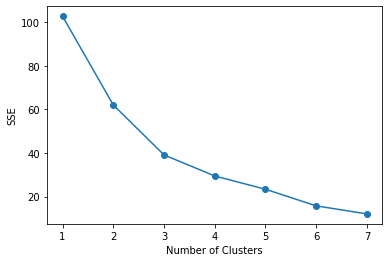

In [26]:
sse = []
for i in range(1,8):
    km = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
    km.fit(reduced_features)
    sse.append(km.inertia_)
    
plt.plot(range(1, 8), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

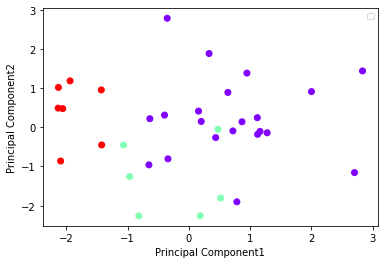

In [65]:
plt.cm.rainbow(0.5)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), cmap='rainbow')
plt.legend(fontsize='small')
# plt.text(reduced_features[:,0], reduced_features[:,1], list(range(1,35)))
plt.xlabel('Principal Component1')
plt.ylabel('Principal Component2')
plt.show()
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [27]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.06799426907266358

In [28]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.06799426907266358

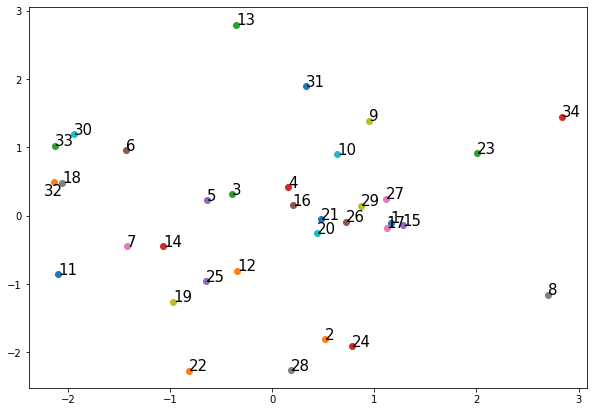

In [40]:
plt.figure(figsize=(10,7))
idx = 1
for x in reduced_features:
    plt.scatter(x[0],x[1])
    if idx==32:
        plt.text(x[0]-0.1,x[1]-0.2,idx, fontsize=15)
    else:
        plt.text(x[0],x[1],idx, fontsize=15)
    idx+=1
plt.show()

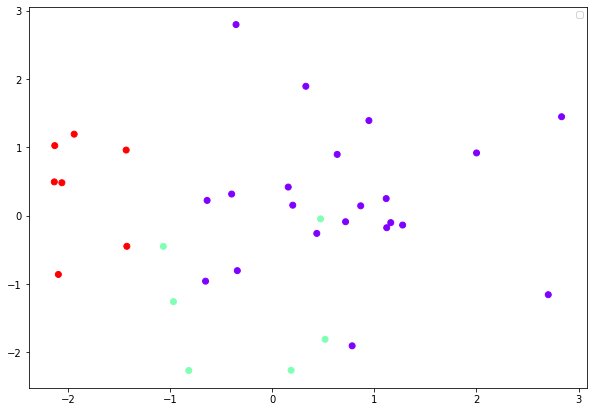

In [31]:
plt.figure(figsize=(10,7))
plt.cm.rainbow(0.5)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features), cmap='rainbow')
plt.legend(fontsize='small')
# plt.text(reduced_features[:,0], reduced_features[:,1], list(range(1,35)))
plt.show()
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [32]:
random_state = 52

pca = KernelPCA(n_components=3, random_state=random_state)
# reduced_feature"s_tfidf_abstract = pca.fit_transform(features.toarray())
reduced_features_bert_3d = pca.fit_transform(features)

Text(0.5, 0, 'Principal Component 3')

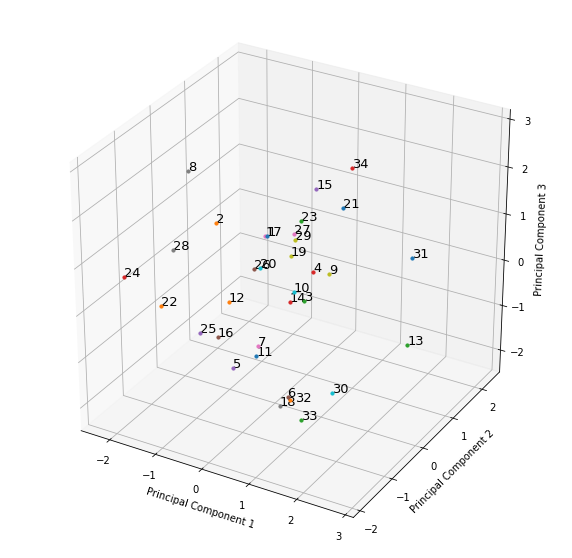

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='3d')

idx=1
for x in reduced_features_bert_3d:
    
    ax2.scatter(x[1],x[2],x[0], s=10)
    if idx==32:
        ax2.text(x[1]+0.1,x[2],x[0],idx, fontsize=13)
    else:
        ax2.text(x[1],x[2],x[0],idx, fontsize=13)
    idx+=1
ax2.set_xlabel('Principal Component 1', fontsize = 10)
ax2.set_ylabel('Principal Component 2', fontsize = 10)
ax2.set_zlabel('Principal Component 3', fontsize = 10)
# ax2.set_title('3 Component PCA', fontsize = 20)

# colors = ["#7fc97f","#beaed4","#fdc086","#ffff99","#386cb0","#f0027f","","#666666"]
# for label, color in zip(labels, colors):
#   indicesToKeep = finalDataFrame2['label'] == label
#   ax2.scatter(finalDataFrame2.loc[indicesToKeep, 'principal component 1']
#                , finalDataFrame2.loc[indicesToKeep, 'principal component 2']
#                , finalDataFrame2.loc[indicesToKeep, 'principal component 3']
#                , c = color
#                , s = 30)

# ax2.legend(labels)
# ax2.grid()